In [50]:
sentence_models = [
    "all-distilroberta-v1",
    "all-MiniLM-L6-v1",
    "all-MiniLM-L6-v2",
    "all-MiniLM-L12-v2",
    "all-mpnet-base-v2",
    "all-roberta-large-v1",
    "multi-qa-mpnet-base-dot-v1",
    "paraphrase-albert-small-v2",
    "paraphrase-multilingual-MiniLM-L12-v2",
    "paraphrase-multilingual-mpnet-base-v2"
]

In [37]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, ConfusionMatrixDisplay

from reader import to_embeddings, get_loader, get_sentence_model
from autoencoder import AutoEncoder

In [34]:
def train(model, loader, device, save_path="checkpoint.pth", num_epochs=30):
    losses = []
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch in loader:
            batch = batch.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(batch)
            
            loss = criterion(outputs, batch)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * batch.size(0)
            
        epoch_loss = running_loss / len(loader.dataset)

        losses.append(epoch_loss)
        
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Save to original path for backward compatibility
    torch.save(model.state_dict(), save_path)
    
    # Get embedding dimension from model's input dimension
    embedding_dim = model.encoder[0].in_features
    
    # Get model name from the dataset with fallback
    model_name = getattr(loader.dataset, 'model_name', "all-MiniLM-L6-v2")
    clean_model_name = model_name.replace("/", "_").replace("-", "_")
    
    # Create dynamic save path using both model name and embedding dimension
    dynamic_save_path = f"model_{clean_model_name}_AE{embedding_dim}.pth"
    torch.save(model.state_dict(), dynamic_save_path)
    print(f"Model also saved to: {dynamic_save_path}")

    return losses

In [16]:
def classify_prompt(prompt, model, sentence_model, threshold, device):
    emb = sentence_model.encode(prompt, convert_to_tensor=True).clone().detach().to(device)
    emb = emb.unsqueeze(0)
    
    model.eval()

    with torch.no_grad():
        recon = model(emb)
        
        error = torch.mean((recon - emb) ** 2, dim=1).item()


    classification = 1 if error < threshold else 0

    return error, classification

In [31]:
def save_results(model_name, metrics, cm, directory):
    # Create results directory with model name
    results_dir = f'{directory}/{model_name}'
    os.makedirs(results_dir, exist_ok=True)
    
    metrics.to_csv(f'{results_dir}/metrics.csv', index=False)

    # Create a ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
    
    # Plot the confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    
    # Customize the plot (optional)
    plt.title('Confusion Matrix')
    plt.savefig(f'{results_dir}/confusion_matrix.png')

In [ ]:

X_train = pd.read_csv("./data/train.csv")['prompt'].tolist()
X_eval = pd.read_csv("data/test.csv")['prompt'].tolist()

jbb = load_dataset("JailbreakBench/JBB-Behaviors", "behaviors")
wikiqa = load_dataset("microsoft/wiki_qa")

harmful_prompts = jbb['harmful']['Goal']
questions = list(set(wikiqa['test']['question']))

df_normal = pd.DataFrame({
    'prompt': questions,
    'label': 0
})

df_harmful = pd.DataFrame({
    'prompt': harmful_prompts,
    'label': 1
})

X_test = pd.concat([df_normal, df_harmful], ignore_index=True) # Load test data

device

In [ ]:
for model_name in sentence_models:
    print(f"Training a model w/ {model_name} as its embedding")
    
    train_embeddings = to_embeddings(X_train, device, model_name=model_name)
    train_loader = get_loader(train_embeddings, shuffle=True, model_name=model_name)
    
    input_dim = train_embeddings.shape[1]
    model = AutoEncoder(input_dim=input_dim).to(device)
    
    losses = train(model, train_loader, device) 
    
    eval_embeddings = to_embeddings(X_eval, device, model_name=model_name)
    eval_loader = get_loader(eval_embeddings, model_name=model_name)
    
    # Calculate reconstruction errors
    model.eval()
    all_errors = []
    
    with torch.no_grad():
        for batch in eval_loader:
            batch = batch.to(device)
            recon_batch = model(batch)
            batch_errors = torch.mean((recon_batch - batch) ** 2, dim=1)
            all_errors.extend(batch_errors.cpu().numpy())
    
    reconstruction_errors = np.array(all_errors)
    print(f"Average Reconstruction Error on Evaluation Set: {np.mean(reconstruction_errors):.4f}")

    threshold_percentile = 95 
    threshold = np.percentile(reconstruction_errors, threshold_percentile)
    print("Threshold set at the {}th percentile: {:.4f}".format(threshold_percentile, threshold))

    sentence_model = get_sentence_model(device, model_name=model_name)

    
    # Run on the test set with data including normal prompts (WikiQA)
    errors = []
    predictions = []
    
    for idx, row in X_test.iterrows():
        prompt = row['prompt']
        # Classify the prompt (classification: 0 for normal, 1 for harmful)
        error, classification = classify_prompt(prompt, model, sentence_model, threshold, device)
        errors.append(error)
        predictions.append(classification)
    
    cm = confusion_matrix(X_test['label'].tolist(), predictions, labels=[0, 1]) 
    print("Confusion Matrix (rows: true labels, columns: predicted labels):")
    print(cm)

    accuracy = accuracy_score(y_true=X_test['label'].tolist(), y_pred=predictions)
    f1 = f1_score(y_true=X_test['label'].tolist(), y_pred=predictions)
    precision = precision_score(y_true=X_test['label'].tolist(), y_pred=predictions)
    recall = recall_score(y_true=X_test['label'].tolist(), y_pred=predictions)

    metrics_df = pd.DataFrame({
        'metric': ['accuracy', 'f1', 'precision', 'recall', 'threshold'],
        'value': [accuracy, f1, precision, recall, threshold]
    })

    save_results(model_name, metrics_df, cm, f"results/test")


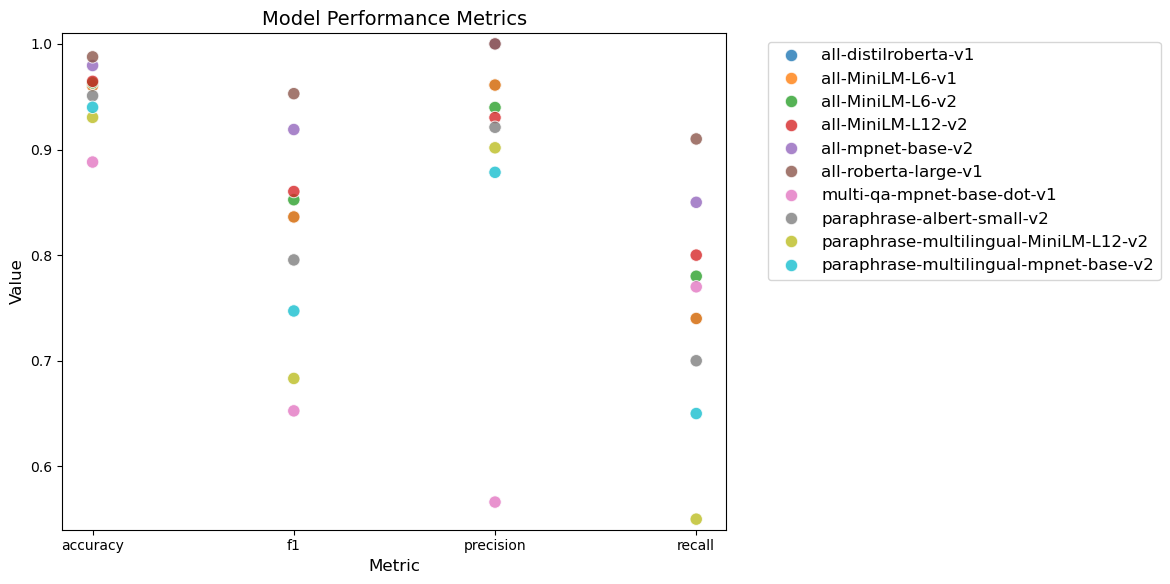

In [61]:
import seaborn as sns

metrics_dict = {}

for model in sentence_models:
    directory = f'results/test/{model}'
    filepath = os.path.join(directory, 'metrics.csv')
    
    # Suppose each CSV has two columns: "metric" and "value"
    df = pd.read_csv(filepath)
    # Pivot so that "metric" is the index and "value" is the data
    s = df.set_index('metric')['value']
    metrics_dict[model] = s

# Combine into a single DataFrame: rows=Models, columns=Metrics
results_df = pd.DataFrame(metrics_dict).T

# List the metrics in the order you want to plot
metric_names = ['accuracy', 'f1', 'precision', 'recall']

# Filter results_df to only include these metrics
filtered_df = results_df[metric_names]

# Reshape DataFrame for plotting
results_long = filtered_df.reset_index().melt(id_vars='index', var_name='metric', value_name='value')
results_long.rename(columns={'index': 'model'}, inplace=True)

# Create color palette for models
unique_models = results_long['model'].unique()
palette = sns.color_palette("tab10", len(unique_models))
model_colors = dict(zip(unique_models, palette))

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=results_long,
    x='metric',
    y='value',
    hue='model',
    palette=model_colors,
    s=80,  # Fixed size for all points
    alpha=0.8
)

# Normalize y-axis to start from minimum value
ymin = results_long['value'].min() - 0.01  # small buffer for visibility
ymax = results_long['value'].max() + 0.01
plt.ylim(ymin, ymax)

plt.title("Model Performance Metrics")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("results/test/comparative_analysis.png")
plt.show()